In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_selection import SelectFromModel

import seaborn as sns

# internal modules
from functions.features import edit_features
from functions.check_nan import just_check_nan
from functions.target import y_target
from functions.var_type import var_cat, var_num
from functions.pipeline import f_pipeline
from functions.plot_learning_curve import plot_learned
from functions.metrics import conf_matrix, aucur, roc_curves
from functions.feature_select import recursive_feature_elimination, select_from_model, recursive_feature_elimination_cv

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os

os.chdir('D:/Meus documentos/Trabalhos/python/exercicios/exemplaria/turma-2019-1/data/intermediate/')
print('LOCAL DE DATABASES')
print()
print(os.getcwd())
print()
print('LISTA DE DATABASES \n\n -', end ='')
print(*os.listdir(), sep = '\n -')

Using TensorFlow backend.


LOCAL DE DATABASES

D:\Meus documentos\Trabalhos\python\exercicios\exemplaria\turma-2019-1\data\intermediate

LISTA DE DATABASES 

 -.gitignore
 -count_plot.png
 -df_complainers.csv
 -sample.csv
 -sample_without_nan.csv
 -target.csv


* **reading df_complainers file**

In [2]:
# reading df_complainers file
df_complainers_filename = '../intermediate/df_complainers.csv'
#df_complainers = pd.read_csv(df_complainers_filename, low_memory=False)
print('Loaded file: ' + df_complainers_filename)

Loaded file: ../intermediate/df_complainers.csv


* **reading clients_sample file**

In [3]:
# reading clients_sample file
filename_without_nan = '../intermediate/sample_without_nan.csv'
clients_sample = pd.read_csv(filename_without_nan, low_memory=False)
print('Loaded file: ' + filename_without_nan)

Loaded file: ../intermediate/sample_without_nan.csv


* **check_nan**

In [4]:
just_check_nan(clients_sample) # check_nan.py

Dados com NaN:
Series([], dtype: int64)

columns_with_nan.shape (0,)



***
# 4) Definição de target e features

https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

* **Target y function**

In [5]:
#y = y_target(clients_sample, df_complainers)  # target.py

* **Salvar no arquivo checkpoint #4**

In [6]:
# save in the file
target = '../intermediate/target.csv'
#np.savetxt(target, y, delimiter=",", fmt='%s')
print('Saved file: ' + target)

Saved file: ../intermediate/target.csv


* **Carregar arquivo**

In [7]:
# reading file Da base de 126303 clientes, 1371 deles são reclamantes, ou seja, 1.0855%
y = np.loadtxt(target, dtype=int).tolist()

print('Da base de ' + str(len(clients_sample)) + ' clientes, ' + str(Counter(y)[1]) + 
      ' deles são reclamantes, ou seja, %.4f' %float((Counter(y)[1]/len(clients_sample))*100) + '%')

Da base de 126303 clientes, 1371 deles são reclamantes, ou seja, 1.0855%


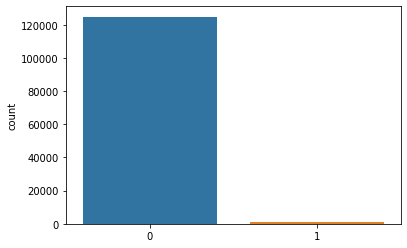

<Figure size 432x288 with 0 Axes>

In [8]:
sns.countplot(x=y, data=clients_sample)
plt.show()
plt.savefig('count_plot')

* **Features X**

In [9]:
# X = clients_sample.drop(['cssocialsecno_encrypted'], axis=1)
X = clients_sample

# 5) Variaveis categóricas - montar por categorias

* Filtrando as 31 categorias de 'contract_status_reason' em 3 no total.
* Substituição das 31 categorias em 3 no total.

In [10]:
edit_features(X) # features.py

In [11]:
X = clients_sample.drop(['cssocialsecno_encrypted'], axis=1)

**billing_ticket_m0** é a feature mais importante

seguido de **customer_tenure**

depois **m0_call_term_err**

In [12]:
X.groupby(y).mean()

,customer_tenure,m0_qt_involuntary_suspension,m0_qt_voluntary_suspension,nxt_3g_traffic_volume_m0,nxt_4g_traffic_volume_m0,vivo_traffic_volume_m0,contract_loyalty_flag,m0_call_term_err,billing_ticket_m0,billing_ticket_m1,billing_ticket_m2,billing_ticket_m3,billing_ticket_m4,billing_ticket_m5
0,45.258385,0.014520,0.000208,1.842274e+09,8.212733e+08,8.460852e+07,0.588256,276.618472,0.036860,0.038093,0.046954,0.046745,0.041719,0.052308
1,59.726780,0.021152,0.001459,1.579244e+09,7.491833e+08,7.998123e+07,0.571845,264.803063,0.364697,0.384391,0.277899,0.189643,0.164843,0.211524


In [13]:
# X['m2_call_term_err'].unique()

# 6) train_test_split

In [14]:
# 70% for train data and 30% for test data SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.4,
                                                    random_state=42)

# 7) Pipeline

* **Criando uma lista de variaveis categoricas**

In [15]:
object_cols = var_cat(X_train)

Categorical variables:  6
['person_type', 'payment_method', 'inar_rate_plan', 'contract_status', 'contract_status_reason', 'device_type_m0']


* **Criando uma lista de variaveis numéricas**

In [16]:
numerical_cols = var_num(X_train)

Numerical variables:  14
['customer_tenure', 'm0_qt_involuntary_suspension', 'm0_qt_voluntary_suspension', 'nxt_3g_traffic_volume_m0', 'nxt_4g_traffic_volume_m0', 'vivo_traffic_volume_m0', 'contract_loyalty_flag', 'm0_call_term_err', 'billing_ticket_m0', 'billing_ticket_m1', 'billing_ticket_m2', 'billing_ticket_m3', 'billing_ticket_m4', 'billing_ticket_m5']


* **Define Preprocessing Steps**, **Define the model** and **Create and Evaluate the Pipeline**

In [17]:
pipeline_all = f_pipeline(numerical_cols, object_cols)
pipeline = pipeline_all[0]

* **Model**

In [18]:
model = pipeline_all[1]

* **Fit**

In [19]:
# Preprocessing of training data, fit model 
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                             

* **Predict**

In [20]:
# Preprocessing of validation data, get predictions
preds = pipeline.predict(X_test)
print('preds: ', Counter(preds))

preds:  Counter({0: 45346, 1: 5176})


# 8) Metricas

In [21]:
# recursive_feature_elimination(X_train, y_train, model)

In [22]:
# recursive_feature_elimination_cv(X_train, y_train, model)

* **Plotting Learning Curves**

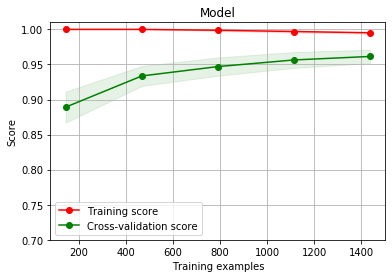

In [23]:
plot_learned(model)

* options
http://scikit-learn.org/stable/modules/model_evaluation.html

* **mean_absolute_error - The best value is 0.0**

In [24]:
# Evaluate the model
print('MAE:', mean_absolute_error(y_test, preds))

MAE: 0.1018962036340604


* **Confusion matrix**

https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

In [25]:
print('X_train.shape: ', X_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_train.shape: ', len(y_train))
print('y_test.shape: ', len(y_test))
print()
print('y_train: ', Counter(y_train))
print()
print('y_test: ', Counter(y_test))
print('preds: ', Counter(preds))

X_train.shape:  (75781, 20)
X_test.shape:  (50522, 20)
y_train.shape:  75781
y_test.shape:  50522

y_train:  Counter({0: 74956, 1: 825})

y_test:  Counter({0: 49976, 1: 546})
preds:  Counter({0: 45346, 1: 5176})


In [26]:
conf_matrix(preds, y_test)

               Actual Values
           +--------+--------+
           | Neg(0) | Pos(1) |
p +--------+--------+--------+
r | Neg(0) | 45087  | 259    |
e +--------+--------+--------+
d | Pos(1) | 4889   | 287    |
s +--------+--------+--------+


* **Curva AUC-ROC - Diz quanto modelo é capaz de distinguir entre classes**

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5


AUC: 0.714


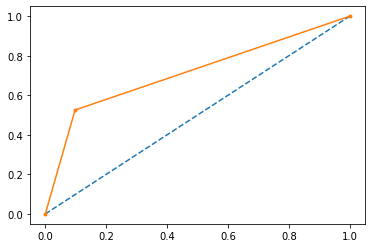

In [27]:
aucur(y_test, preds)

* **Precision recall - é uma medida do sucesso da previsão quando as classes estão muito desequilibradas**

* accuracy ((TP+TN)/(TP+FP+TN+FN))


* precision (TN/(TN+FP))


* recall (TN/(TN+FN))

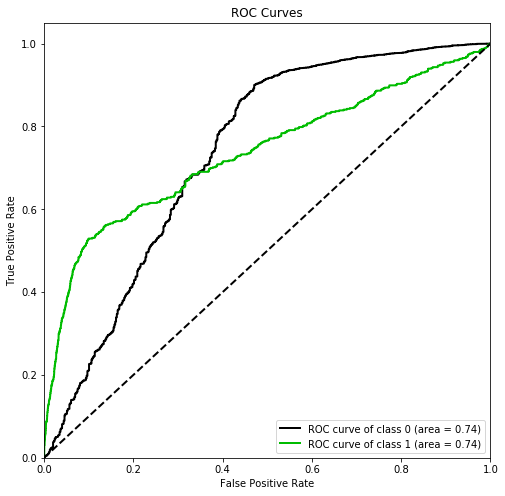

In [28]:
roc_curves(X_test, y_test, pipeline)

* **Classification report**

https://docs.google.com/document/d/1pjpX9xQPdVgeJjKakVSYuqRReEyrZesD3-aD61Z-0wQ/edit

**precision** é a capacidade de um classificador de não rotular uma instância de positiva como realmente negativa. Para cada classe, é definida como a razão entre os verdadeiros positivos e a soma dos verdadeiros positivos e falsos **positivos**. Dito de outra maneira, "para todos os casos classificados como positivos, qual porcentagem estava correta?"
**Caso: O modelo previu 5176 reclamantes, acertou 287, precisão de 6%**

**recall** é capacidade de um classificador encontrar todas as instâncias positivas. Para cada classe, é definida como a razão entre os verdadeiros positivos e a soma dos verdadeiros positivos e falsos **negativos**. Dito de outra maneira, "para todas as instâncias que foram realmente positivas, qual porcentagem foi classificada corretamente?"
**Caso: Dos 546 casos reais de reclamantes, ele acertou 287, que é 53%**

**F1 score** é uma média harmônica ponderada de **precision** e **recall**, de modo que a melhor pontuação seja 1,0 e a pior seja 0,0. De um modo geral, os valores de F1 score são mais baixas do que as medidas de **precision** como eles incorporam **precision** e **recall** em seu cálculo.

**support** é o número de ocorrências reais da classe no conjunto de dados especificado. O suporte desequilibrado nos dados de treinamento pode indicar fragilidades estruturais nas pontuações relatadas do classificador e pode indicar a necessidade de amostragem estratificada ou reequilíbrio. O suporte não muda entre os modelos, mas sim diagnostica o processo de avaliação.

In [29]:
# classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.90      0.95     49976
           1       0.06      0.53      0.10       546

    accuracy                           0.90     50522
   macro avg       0.52      0.71      0.52     50522
weighted avg       0.98      0.90      0.94     50522

